In [1]:
#Basic AstroCV example 3
#Detect galaxies in online images
#Optimal image ratio = 4:3 (ratio of traning images)
#Detects galaxies in online images, then crops them so they have a 4:3 ratio, and compares number of galaxies detected in the cropped zone


import sys     
import pyyolo
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import time
import urllib
import os.path

In [2]:
if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    # Not Python 3 - today, it is most likely to be Python 2
    # But note that this might need an update when Python 4
    # might be around one day
    from urllib import urlretrieve
    
## This code imports urlretrieve from the right library, since they're different for Python versions 2 and  3
    
##code from https://stackoverflow.com/questions/17960942/attributeerror-module-object-has-no-attribute-urlretrieve

In [3]:
darknet_path = './data/darknet' #darknet path
datacfg = '../sdss.data' #relative to darknet path
cfgfile = '../sdss.cfg' #relative to darknet path
weightfile = '/mnt/data/astrocv/galaxy_sdss_hic.weights'
filename = 'writable/tempImageDownload.jpg' #relative to galaxy_detection path


##Three images with bad ratios

#url = "https://www.nasa.gov/sites/default/files/thumbnails/image/hubble_friday_03112016.jpg" #square image
#url = "http://wwwcdn.skyandtelescope.com/wp-content/uploads/a-galaxy-cluster-1.jpg" #tall image
url = "https://i.kinja-img.com/gawker-media/image/upload/s--RkydXzP0--/c_scale,fl_progressive,q_80,w_800/t4eipzajwxxfp3retytv.jpg" #wide image


if not os.path.isfile(filename):
    urlretrieve(url,filename)
thresh = 0.1  #detection threshold try 0.02 & 0.1
hier_thresh = 0.5

In [4]:
##The following code crops the image to a good image ratio.
##It won't crop the image if the ratio is ~4:3

img = Image.open(filename)
width, height = img.size
ratio=width/height

cropped = False
if abs(ratio-(4/3))>0.05:
        cropped = True
        if ratio<=(4/3):
                fheight=int(width*(3/4))
                img2 = img.crop((0, 0, width, fheight))
        else:
                fwidth = int(height*4/3)
                img2 = img.crop((0, 0, fwidth, height))
         
        img2.save("writable/tempImageDownload2.jpg")
        filename2="writable/tempImageDownload2.jpg"
        
        

In [5]:
t1=time.time()
pyyolo.init(darknet_path, datacfg, cfgfile, weightfile) #init and load network
print('Initialization time = %5.3f seconds'%(time.time()-t1))
t1=time.time()
outputs = pyyolo.test(filename, thresh, hier_thresh, 0) #load image and process
print('Image processing time = %5.3f seconds'%(time.time()-t1))

asd=0

for output in outputs:
        asd+=1
        print(output)
        
print("%d images detected"%asd)
pyyolo.cleanup()


Initialization time = 4.685 seconds
Image processing time = 0.378 seconds
{'right': 353, 'top': 28, 'left': 329, 'bottom': 49, 'class': 'Elliptical ', 'prob': 0.2061178982257843}
{'right': 707, 'top': 97, 'left': 690, 'bottom': 110, 'class': 'Elliptical ', 'prob': 0.3612126111984253}
{'right': 56, 'top': 106, 'left': 40, 'bottom': 120, 'class': 'Elliptical ', 'prob': 0.5188971757888794}
{'right': 313, 'top': 113, 'left': 297, 'bottom': 128, 'class': 'Elliptical ', 'prob': 0.18978914618492126}
{'right': 413, 'top': 115, 'left': 395, 'bottom': 131, 'class': 'Elliptical ', 'prob': 0.12341348826885223}
{'right': 435, 'top': 146, 'left': 420, 'bottom': 158, 'class': 'Elliptical ', 'prob': 0.14909452199935913}
{'right': 168, 'top': 196, 'left': 155, 'bottom': 207, 'class': 'Elliptical ', 'prob': 0.16645939648151398}
{'right': 603, 'top': 211, 'left': 587, 'bottom': 225, 'class': 'Elliptical ', 'prob': 0.15027940273284912}
{'right': 766, 'top': 230, 'left': 749, 'bottom': 246, 'class': 'Ellip

In [6]:
##Here we process the cropped image, if cropped

if cropped:
    t2=time.time()
    pyyolo.init(darknet_path, datacfg, cfgfile, weightfile) #init and load network
    print('Initialization time = %5.3f seconds'%(time.time()-t2))
    t2=time.time()
    outputs2 = pyyolo.test(filename2, thresh, hier_thresh, 0) #load image and process
    print('Image processing time = %5.3f seconds'%(time.time()-t2))

    asd=0

    for output in outputs2:
            asd+=1
            print(output)

    print("%d images detected"%asd)
    pyyolo.cleanup()

Initialization time = 4.043 seconds
Image processing time = 0.303 seconds
{'right': 577, 'top': 40, 'left': 568, 'bottom': 50, 'class': 'Elliptical ', 'prob': 0.20594197511672974}
{'right': 57, 'top': 104, 'left': 39, 'bottom': 122, 'class': 'Elliptical ', 'prob': 0.2712832987308502}
{'right': 313, 'top': 112, 'left': 297, 'bottom': 129, 'class': 'Elliptical ', 'prob': 0.15606918931007385}
{'right': 532, 'top': 175, 'left': 518, 'bottom': 189, 'class': 'Elliptical ', 'prob': 0.10395385324954987}
{'right': 105, 'top': 226, 'left': 87, 'bottom': 244, 'class': 'Edge-on', 'prob': 0.11555518954992294}
{'right': 427, 'top': 259, 'left': 402, 'bottom': 279, 'class': 'Edge-on', 'prob': 0.13383744657039642}
{'right': 351, 'top': 277, 'left': 336, 'bottom': 291, 'class': 'Elliptical ', 'prob': 0.31840819120407104}
{'right': 251, 'top': 300, 'left': 237, 'bottom': 313, 'class': 'Elliptical ', 'prob': 0.512548565864563}
{'right': 57, 'top': 305, 'left': 40, 'bottom': 322, 'class': 'Elliptical ', '

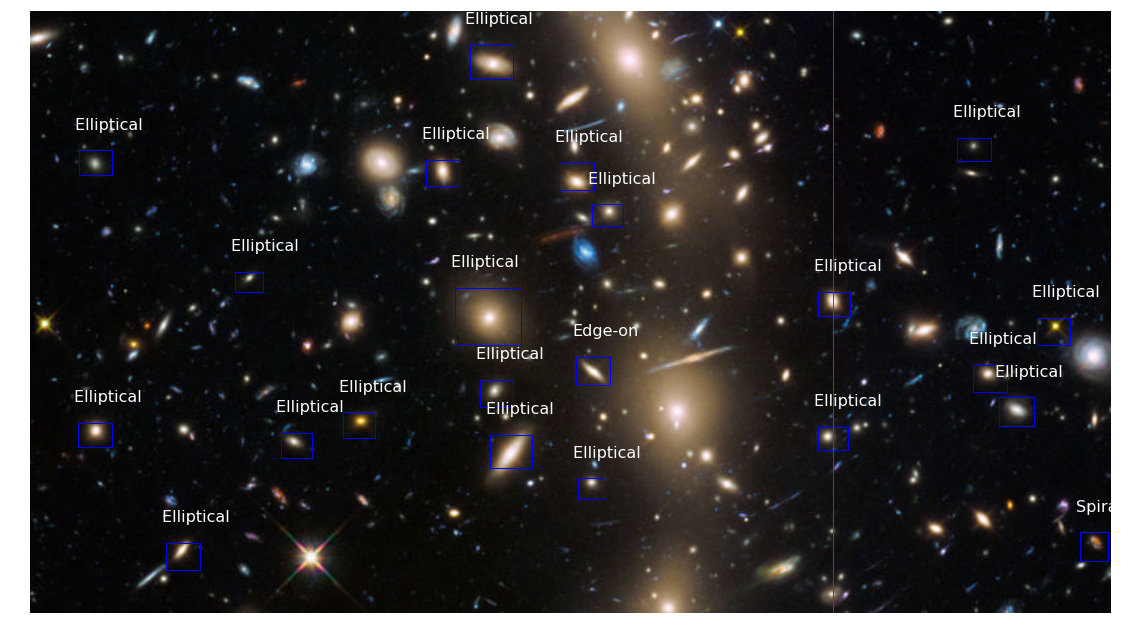

In [7]:
#plot image and detections
#plot red line showing where the crop was made (always above or at the left side of the line)


img = Image.open(filename)
contrast = ImageEnhance.Contrast(img)
img2 = contrast.enhance(1)
fig,ax = plt.subplots(figsize=(15,12))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(img2)
ax.set_aspect('equal')

inliers = 0
for output in outputs:
        r=output['right']
        l=output['left']
        t=output['top']
        b=output['bottom']
        if cropped:
                if width/height<4/3:
                        if b<fheight:
                                inliers+=1
                else:
                        if r<fwidth:
                                inliers+=1

                                
                                
        rect = patches.Rectangle((l-4,t-3),r-l+8,b-t+4,linewidth=1,edgecolor='b',facecolor='none')      
        ax.add_patch(rect)
        ax.annotate(output['class'],(l-7,t-19),color='w',fontsize=16)
        


if cropped:
        if width/height<4/3:
                plt.axhline(fheight,color='red')
        else:
                plt.axvline(fwidth,color='red')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0) 
plt.show()


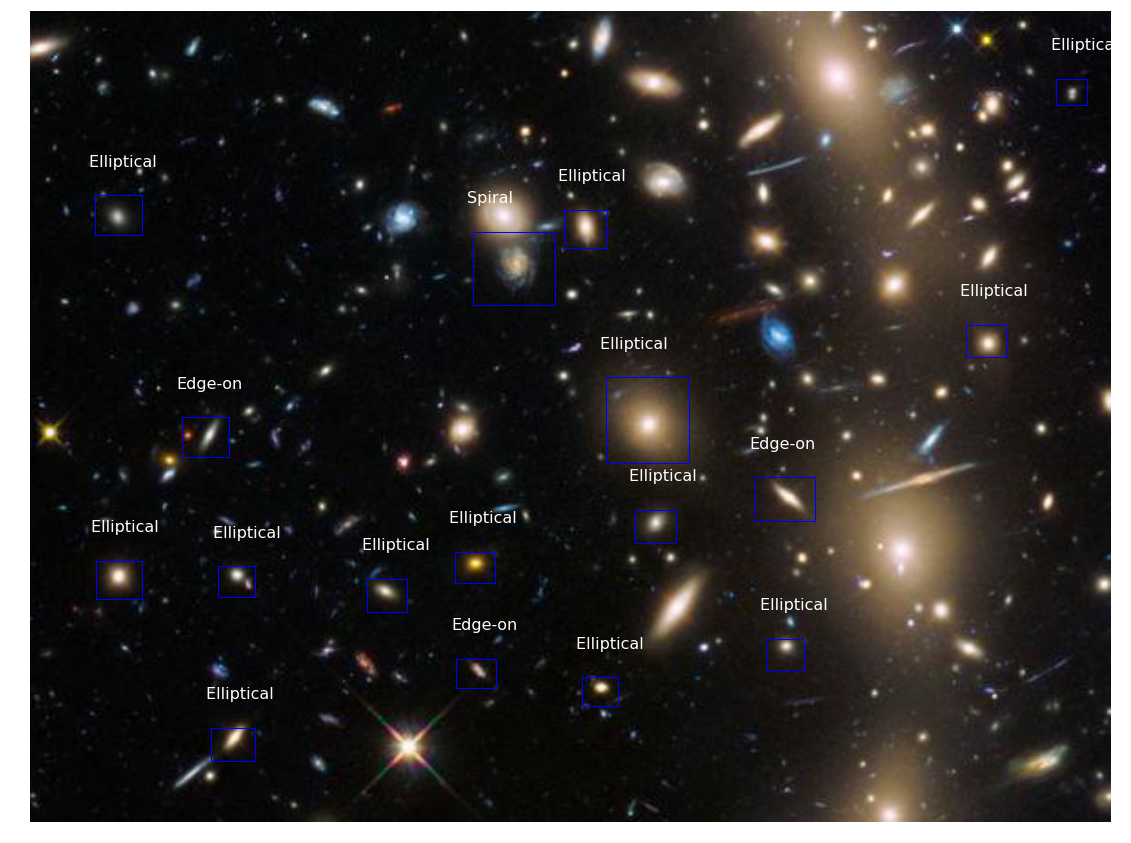

In [8]:
#plot image and detections for cropped image
img = Image.open(filename2)
contrast = ImageEnhance.Contrast(img)
img2 = contrast.enhance(1)
fig,ax = plt.subplots(figsize=(15,12))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(img2)
ax.set_aspect('equal')


for output in outputs2:
        r=output['right']
        l=output['left']
        t=output['top']
        b=output['bottom']
           
        rect = patches.Rectangle((l-4,t-3),r-l+8,b-t+4,linewidth=1,edgecolor='b',facecolor='none')      
        ax.add_patch(rect)
        ax.annotate(output['class'],(l-7,t-19),color='w',fontsize=16)
        


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0) 
plt.show()

In [9]:
print("In the raw image, %d galaxies were found in the area to be cropped"%inliers)
print("In the cropped image, %d galaxies were found"%asd )

In the raw image, 15 galaxies were found in the area to be cropped
In the cropped image, 17 galaxies were found


In [10]:
os.remove("writable/tempImageDownload.jpg")
os.remove("writable/tempImageDownload2.jpg")
##deletes temp images after downloading

In [11]:
%%javascript
IPython.notebook.kernel.restart();

<IPython.core.display.Javascript object>